# Introduction: Home Credit Default Risk


# Data

The data is provided by [Home Credit](http://www.homecredit.net/about-us.aspx), a service dedicated to provided lines of credit (loans) to the unbanked population. Predicting whether or not a client will repay a loan or have difficulty is a critical business need, and Home Credit is hosting this competition on Kaggle to see what sort of models the machine learning community can develop to help them in this task. 

There are 7 different sources of data:

* application_train/application_test: the main training and testing data with information about each loan application at Home Credit. Every loan has its own row and is identified by the feature `SK_ID_CURR`. The training application data comes with the `TARGET` indicating 0: the loan was repaid or 1: the loan was not repaid. 
* bureau: data concerning client's previous credits from other financial institutions. Each previous credit has its own row in bureau, but one loan in the application data can have multiple previous credits.
* bureau_balance: monthly data about the previous credits in bureau. Each row is one month of a previous credit, and a single previous credit can have multiple rows, one for each month of the credit length. 
* previous_application: previous applications for loans at Home Credit of clients who have loans in the application data. Each current loan in the application data can have multiple previous loans. Each previous application has one row and is identified by the feature `SK_ID_PREV`. 
* POS_CASH_BALANCE: monthly data about previous point of sale or cash loans clients have had with Home Credit. Each row is one month of a previous point of sale or cash loan, and a single previous loan can have many rows.
* credit_card_balance: monthly data about previous credit cards clients have had with Home Credit. Each row is one month of a credit card balance, and a single credit card can have many rows.
* installments_payment: payment history for previous loans at Home Credit. There is one row for every made payment and one row for every missed payment. 

This diagram shows how all of the data is related:

![image](https://storage.googleapis.com/kaggle-media/competitions/home-credit/home_credit.png)

Moreover, we are provided with the definitions of all the columns (in `HomeCredit_columns_description.csv`) and an example of the expected submission file. 

## Metric: ROC AUC

Once we have a grasp of the data (reading through the [column descriptions](https://www.kaggle.com/c/home-credit-default-risk/data) helps immensely), we need to understand the metric by which our submission is judged. In this case, it is a common classification metric known as the [Receiver Operating Characteristic Area Under the Curve (ROC AUC, also sometimes called AUROC)](https://stats.stackexchange.com/questions/132777/what-does-auc-stand-for-and-what-is-it).

The ROC AUC may sound intimidating, but it is relatively straightforward once you can get your head around the two individual concepts. The [Reciever Operating Characteristic (ROC) curve](https://en.wikipedia.org/wiki/Receiver_operating_characteristic) graphs the true positive rate versus the false positive rate:

![image](http://www.statisticshowto.com/wp-content/uploads/2016/08/ROC-curve.png)

A single line on the graph indicates the curve for a single model, and movement along a line indicates changing the threshold used for classifying a positive instance. The threshold starts at 0 in the upper right to and goes to 1 in the lower left. A curve that is to the left and above another curve indicates a better model. For example, the blue model is better than the red model, which is better than the black diagonal line which indicates a naive random guessing model. 

The [Area Under the Curve (AUC)](http://gim.unmc.edu/dxtests/roc3.htm) explains itself by its name! It is simply the area under the ROC curve. (This is the integral of the curve.) This metric is between 0 and 1 with a better model scoring higher. A model that simply guesses at random will have an ROC AUC of 0.5.

When we measure a classifier according to the ROC AUC, we do not generation 0 or 1 predictions, but rather a probability between 0 and 1. This may be confusing because we usually like to think in terms of accuracy, but when we get into problems with inbalanced classes (we will see this is the case), accuracy is not the best metric. For example, if I wanted to build a model that could detect terrorists with 99.9999% accuracy, I would simply make a model that predicted every single person was not a terrorist. Clearly, this would not be effective (the recall would be zero) and we use more advanced metrics such as ROC AUC or the [F1 score](https://en.wikipedia.org/wiki/F1_score) to more accurately reflect the performance of a classifier. A model with a high ROC AUC will also have a high accuracy, but the [ROC AUC is a better representation of model performance.](https://datascience.stackexchange.com/questions/806/advantages-of-auc-vs-standard-accuracy)

## List of Check Point
- CP #1 : Preparation 
- CP #2 : Data Quick look 
- CP #3 : Miscellaneous Handling
- CP #4 : Selection & Subset
- CP #5 : Transformation
- CP #6: Joining table
- CP #7: Aggregation & Sorting
- CP #8: Visualization
- CP #9: Dummy Var & Split Data
- CP #10 : Modeling


# 1. Preparation

In [1]:
# numpy and pandas for data manipulation
import numpy as np
import pandas as pd 

# sklearn preprocessing for dealing with categorical variables
from sklearn.preprocessing import LabelEncoder

# File system manangement
import os

# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')

# matplotlib and seaborn for plotting
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime as dt

In [2]:
application_train = pd.read_csv('application_train.csv')
POS_CASH_balance = pd.read_csv('POS_CASH_balance.csv')
bureau_balance = pd.read_csv('bureau_balance.csv')
previous_application = pd.read_csv('previous_application.csv')
installments_payments = pd.read_csv('installments_payments.csv')
credit_card_balance = pd.read_csv('credit_card_balance.csv')
bureau = pd.read_csv('bureau.csv')
application_test = pd.read_csv('application_test.csv')

# 2. Data Quick Look

## Data Shape

In [3]:
print('Size of application_train data', application_train.shape)
print('Size of POS_CASH_balance data', POS_CASH_balance.shape)
print('Size of bureau_balance data', bureau_balance.shape)
print('Size of previous_application data', previous_application.shape)
print('Size of installments_payments data', installments_payments.shape)
print('Size of credit_card_balance data', credit_card_balance.shape)
print('Size of bureau data', bureau.shape)
print('Size of application_test data', application_test.shape)

Size of application_train data (307511, 122)
Size of POS_CASH_balance data (10001358, 8)
Size of bureau_balance data (27299925, 3)
Size of previous_application data (1670214, 37)
Size of installments_payments data (13605401, 8)
Size of credit_card_balance data (3840312, 23)
Size of bureau data (1716428, 17)
Size of application_test data (48744, 121)


## Concat Training and Testing Dataset

In [4]:
application_mix = pd.concat([application_train,application_test],0).reset_index(drop=True)
print('Size of application training and testing data', application_mix.shape)

Size of application training and testing data (356255, 122)


## Data View and Data Type

In [5]:
application_mix.head()

,AMT_ANNUITY,AMT_CREDIT,AMT_GOODS_PRICE,AMT_INCOME_TOTAL,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_YEAR,...,TARGET,TOTALAREA_MODE,WALLSMATERIAL_MODE,WEEKDAY_APPR_PROCESS_START,YEARS_BEGINEXPLUATATION_AVG,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_AVG,YEARS_BUILD_MEDI,YEARS_BUILD_MODE
0,24700.5,406597.5,351000.0,202500.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0149,"Stone, brick",WEDNESDAY,0.9722,0.9722,0.9722,0.6192,0.6243,0.6341
1,35698.5,1293502.5,1129500.0,270000.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0714,Block,MONDAY,0.9851,0.9851,0.9851,0.7960,0.7987,0.8040
2,6750.0,135000.0,135000.0,67500.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,NaN,NaN,MONDAY,NaN,NaN,NaN,NaN,NaN,NaN
3,29686.5,312682.5,297000.0,135000.0,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,NaN,NaN,WEDNESDAY,NaN,NaN,NaN,NaN,NaN,NaN
4,21865.5,513000.0,513000.0,121500.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,NaN,NaN,THURSDAY,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
application_mix.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 356255 entries, 0 to 356254
Columns: 122 entries, AMT_ANNUITY to YEARS_BUILD_MODE
dtypes: float64(66), int64(40), object(16)
memory usage: 331.6+ MB


In [7]:
POS_CASH_balance.head()

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,1803195,182943,-31,48.0,45.0,Active,0,0
1,1715348,367990,-33,36.0,35.0,Active,0,0
2,1784872,397406,-32,12.0,9.0,Active,0,0
3,1903291,269225,-35,48.0,42.0,Active,0,0
4,2341044,334279,-35,36.0,35.0,Active,0,0


In [8]:
POS_CASH_balance.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10001358 entries, 0 to 10001357
Data columns (total 8 columns):
SK_ID_PREV               int64
SK_ID_CURR               int64
MONTHS_BALANCE           int64
CNT_INSTALMENT           float64
CNT_INSTALMENT_FUTURE    float64
NAME_CONTRACT_STATUS     object
SK_DPD                   int64
SK_DPD_DEF               int64
dtypes: float64(2), int64(5), object(1)
memory usage: 610.4+ MB


In [9]:
bureau_balance.head()

,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
0,5715448,0,C
1,5715448,-1,C
2,5715448,-2,C
3,5715448,-3,C
4,5715448,-4,C


In [10]:
bureau_balance.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27299925 entries, 0 to 27299924
Data columns (total 3 columns):
SK_ID_BUREAU      int64
MONTHS_BALANCE    int64
STATUS            object
dtypes: int64(2), object(1)
memory usage: 624.8+ MB


In [11]:
previous_application.head()

,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,...,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,2030495,271877,Consumer loans,1730.430,17145.0,17145.0,0.0,17145.0,SATURDAY,15,...,Connectivity,12.0,middle,POS mobile with interest,365243.0,-42.0,300.0,-42.0,-37.0,0.0
1,2802425,108129,Cash loans,25188.615,607500.0,679671.0,NaN,607500.0,THURSDAY,11,...,XNA,36.0,low_action,Cash X-Sell: low,365243.0,-134.0,916.0,365243.0,365243.0,1.0
2,2523466,122040,Cash loans,15060.735,112500.0,136444.5,NaN,112500.0,TUESDAY,11,...,XNA,12.0,high,Cash X-Sell: high,365243.0,-271.0,59.0,365243.0,365243.0,1.0
3,2819243,176158,Cash loans,47041.335,450000.0,470790.0,NaN,450000.0,MONDAY,7,...,XNA,12.0,middle,Cash X-Sell: middle,365243.0,-482.0,-152.0,-182.0,-177.0,1.0
4,1784265,202054,Cash loans,31924.395,337500.0,404055.0,NaN,337500.0,THURSDAY,9,...,XNA,24.0,high,Cash Street: high,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
previous_application.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1670214 entries, 0 to 1670213
Data columns (total 37 columns):
SK_ID_PREV                     1670214 non-null int64
SK_ID_CURR                     1670214 non-null int64
NAME_CONTRACT_TYPE             1670214 non-null object
AMT_ANNUITY                    1297979 non-null float64
AMT_APPLICATION                1670214 non-null float64
AMT_CREDIT                     1670213 non-null float64
AMT_DOWN_PAYMENT               774370 non-null float64
AMT_GOODS_PRICE                1284699 non-null float64
WEEKDAY_APPR_PROCESS_START     1670214 non-null object
HOUR_APPR_PROCESS_START        1670214 non-null int64
FLAG_LAST_APPL_PER_CONTRACT    1670214 non-null object
NFLAG_LAST_APPL_IN_DAY         1670214 non-null int64
RATE_DOWN_PAYMENT              774370 non-null float64
RATE_INTEREST_PRIMARY          5951 non-null float64
RATE_INTEREST_PRIVILEGED       5951 non-null float64
NAME_CASH_LOAN_PURPOSE         1670214 non-null object
NAME_CONTRA

In [13]:
installments_payments.head()

,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
0,1054186,161674,1.0,6,-1180.0,-1187.0,6948.360,6948.360
1,1330831,151639,0.0,34,-2156.0,-2156.0,1716.525,1716.525
2,2085231,193053,2.0,1,-63.0,-63.0,25425.000,25425.000
3,2452527,199697,1.0,3,-2418.0,-2426.0,24350.130,24350.130
4,2714724,167756,1.0,2,-1383.0,-1366.0,2165.040,2160.585


In [14]:
installments_payments.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13605401 entries, 0 to 13605400
Data columns (total 8 columns):
SK_ID_PREV                int64
SK_ID_CURR                int64
NUM_INSTALMENT_VERSION    float64
NUM_INSTALMENT_NUMBER     int64
DAYS_INSTALMENT           float64
DAYS_ENTRY_PAYMENT        float64
AMT_INSTALMENT            float64
AMT_PAYMENT               float64
dtypes: float64(5), int64(3)
memory usage: 830.4 MB


In [15]:
credit_card_balance.head()

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,...,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,2562384,378907,-6,56.970,135000,0.0,877.5,0.0,877.5,1700.325,...,0.000,0.000,0.0,1,0.0,1.0,35.0,Active,0,0
1,2582071,363914,-1,63975.555,45000,2250.0,2250.0,0.0,0.0,2250.000,...,64875.555,64875.555,1.0,1,0.0,0.0,69.0,Active,0,0
2,1740877,371185,-7,31815.225,450000,0.0,0.0,0.0,0.0,2250.000,...,31460.085,31460.085,0.0,0,0.0,0.0,30.0,Active,0,0
3,1389973,337855,-4,236572.110,225000,2250.0,2250.0,0.0,0.0,11795.760,...,233048.970,233048.970,1.0,1,0.0,0.0,10.0,Active,0,0
4,1891521,126868,-1,453919.455,450000,0.0,11547.0,0.0,11547.0,22924.890,...,453919.455,453919.455,0.0,1,0.0,1.0,101.0,Active,0,0


In [16]:
credit_card_balance.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3840312 entries, 0 to 3840311
Data columns (total 23 columns):
SK_ID_PREV                    int64
SK_ID_CURR                    int64
MONTHS_BALANCE                int64
AMT_BALANCE                   float64
AMT_CREDIT_LIMIT_ACTUAL       int64
AMT_DRAWINGS_ATM_CURRENT      float64
AMT_DRAWINGS_CURRENT          float64
AMT_DRAWINGS_OTHER_CURRENT    float64
AMT_DRAWINGS_POS_CURRENT      float64
AMT_INST_MIN_REGULARITY       float64
AMT_PAYMENT_CURRENT           float64
AMT_PAYMENT_TOTAL_CURRENT     float64
AMT_RECEIVABLE_PRINCIPAL      float64
AMT_RECIVABLE                 float64
AMT_TOTAL_RECEIVABLE          float64
CNT_DRAWINGS_ATM_CURRENT      float64
CNT_DRAWINGS_CURRENT          int64
CNT_DRAWINGS_OTHER_CURRENT    float64
CNT_DRAWINGS_POS_CURRENT      float64
CNT_INSTALMENT_MATURE_CUM     float64
NAME_CONTRACT_STATUS          object
SK_DPD                        int64
SK_DPD_DEF                    int64
dtypes: float64(15), int64(7

In [17]:
bureau.head()

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,Credit card,-20,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,Consumer credit,-16,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.0,NaN,NaN,0.0,Credit card,-16,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.0,NaN,NaN,0.0,Consumer credit,-21,NaN


In [18]:
bureau.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1716428 entries, 0 to 1716427
Data columns (total 17 columns):
SK_ID_CURR                int64
SK_ID_BUREAU              int64
CREDIT_ACTIVE             object
CREDIT_CURRENCY           object
DAYS_CREDIT               int64
CREDIT_DAY_OVERDUE        int64
DAYS_CREDIT_ENDDATE       float64
DAYS_ENDDATE_FACT         float64
AMT_CREDIT_MAX_OVERDUE    float64
CNT_CREDIT_PROLONG        int64
AMT_CREDIT_SUM            float64
AMT_CREDIT_SUM_DEBT       float64
AMT_CREDIT_SUM_LIMIT      float64
AMT_CREDIT_SUM_OVERDUE    float64
CREDIT_TYPE               object
DAYS_CREDIT_UPDATE        int64
AMT_ANNUITY               float64
dtypes: float64(8), int64(6), object(3)
memory usage: 222.6+ MB


## Number of Target

In [19]:
application_mix['TARGET'].value_counts()

0.0    282686
1.0     24825
Name: TARGET, dtype: int64

In [20]:
application_mix['TARGET'].value_counts(normalize=True)

0.0    0.919271
1.0    0.080729
Name: TARGET, dtype: float64

## Statistics Desriptive

In [21]:
application_mix.describe()

,AMT_ANNUITY,AMT_CREDIT,AMT_GOODS_PRICE,AMT_INCOME_TOTAL,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_YEAR,...,REG_REGION_NOT_WORK_REGION,SK_ID_CURR,TARGET,TOTALAREA_MODE,YEARS_BEGINEXPLUATATION_AVG,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_AVG,YEARS_BUILD_MEDI,YEARS_BUILD_MODE
count,356219.000000,3.562550e+05,3.559770e+05,3.562550e+05,308687.000000,308687.000000,308687.000000,308687.000000,308687.000000,308687.000000,...,356255.000000,356255.000000,307511.000000,185200.000000,183392.000000,183392.000000,183392.000000,119949.000000,119949.000000,119949.000000
mean,27425.560657,5.877674e+05,5.280200e+05,1.701161e+05,0.006281,0.005808,0.231697,0.304399,0.029995,1.911564,...,0.051371,278128.000000,0.080729,0.103193,0.977889,0.977903,0.977239,0.752283,0.755548,0.759452
std,14732.808190,3.986237e+05,3.660650e+05,2.235068e+05,0.104250,0.079736,0.855949,0.786915,0.191374,1.865338,...,0.220753,102842.104413,0.272419,0.108041,0.057929,0.058562,0.063165,0.113267,0.112057,0.110112
min,1615.500000,4.500000e+04,4.050000e+04,2.565000e+04,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,100001.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,16731.000000,2.700000e+05,2.340000e+05,1.125000e+05,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,189064.500000,0.000000,0.041500,0.976700,0.976700,0.976700,0.687200,0.691400,0.699400
50%,25078.500000,5.002110e+05,4.500000e+05,1.530000e+05,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,...,0.000000,278128.000000,0.000000,0.069000,0.981600,0.981600,0.981600,0.755200,0.758500,0.764800
75%,34960.500000,7.975575e+05,6.750000e+05,2.025000e+05,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,...,0.000000,367191.500000,0.000000,0.128700,0.986600,0.986600,0.986600,0.823200,0.825600,0.823600
max,258025.500000,4.050000e+06,4.050000e+06,1.170000e+08,9.000000,4.000000,27.000000,261.000000,8.000000,25.000000,...,1.000000,456255.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


# 2.5 Exploratory Data Analysis

### Target Feature

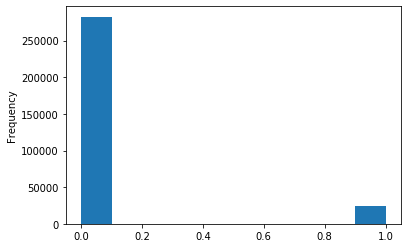

In [22]:
application_mix['TARGET'].plot.hist();

### Number of Unique Category each Column

In [23]:
application_mix.select_dtypes('object').apply(pd.Series.nunique, axis = 0)

CODE_GENDER                    3
EMERGENCYSTATE_MODE            2
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
FONDKAPREMONT_MODE             4
HOUSETYPE_MODE                 3
NAME_CONTRACT_TYPE             2
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             6
NAME_HOUSING_TYPE              6
NAME_INCOME_TYPE               8
NAME_TYPE_SUITE                7
OCCUPATION_TYPE               18
ORGANIZATION_TYPE             58
WALLSMATERIAL_MODE             7
WEEKDAY_APPR_PROCESS_START     7
dtype: int64

### Day Birth

In [24]:
(application_mix['DAYS_BIRTH']).describe()

count    356255.000000
mean     -16041.248841
std        4358.803980
min      -25229.000000
25%      -19676.000000
50%      -15755.000000
75%      -12425.000000
max       -7338.000000
Name: DAYS_BIRTH, dtype: float64

In [25]:
(application_mix['DAYS_BIRTH'] / -365).describe()

count    356255.000000
mean         43.948627
std          11.941929
min          20.104110
25%          34.041096
50%          43.164384
75%          53.906849
max          69.120548
Name: DAYS_BIRTH, dtype: float64

### Days Employe

In [26]:
application_mix['DAYS_EMPLOYED'].describe()

count    356255.000000
mean      64317.231413
std      141705.532576
min      -17912.000000
25%       -2781.000000
50%       -1224.000000
75%        -290.000000
max      365243.000000
Name: DAYS_EMPLOYED, dtype: float64

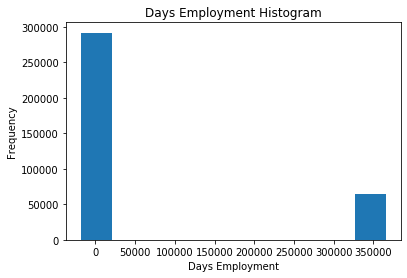

In [27]:
application_mix['DAYS_EMPLOYED'].plot.hist(title = 'Days Employment Histogram');
plt.xlabel('Days Employment');

### Risk Rate from Anomalous

In [28]:
anom = application_mix[application_mix['DAYS_EMPLOYED'] == 365243]
non_anom = application_mix[application_mix['DAYS_EMPLOYED'] != 365243]
print('The non-anomalies default on %0.2f%% of loans' % (100 * non_anom['TARGET'].mean()))
print('The anomalies default on %0.2f%% of loans' % (100 * anom['TARGET'].mean()))
print('There are %d anomalous days of employment' % len(anom))

The non-anomalies default on 8.66% of loans
The anomalies default on 5.40% of loans
There are 64648 anomalous days of employment


### Correlations

In [29]:
# Find correlations with the target and sort
correlations = application_mix.corr()['TARGET'].sort_values()

# Display correlations
print('Most Positive Correlations:\n', correlations.tail(15))
print('\nMost Negative Correlations:\n', correlations.head(15))

Most Positive Correlations:
 DEF_60_CNT_SOCIAL_CIRCLE       0.031276
DEF_30_CNT_SOCIAL_CIRCLE       0.032248
LIVE_CITY_NOT_WORK_CITY        0.032518
OWN_CAR_AGE                    0.037612
DAYS_REGISTRATION              0.041975
FLAG_DOCUMENT_3                0.044346
REG_CITY_NOT_LIVE_CITY         0.044395
FLAG_EMP_PHONE                 0.045982
REG_CITY_NOT_WORK_CITY         0.050994
DAYS_ID_PUBLISH                0.051457
DAYS_LAST_PHONE_CHANGE         0.055218
REGION_RATING_CLIENT           0.058899
REGION_RATING_CLIENT_W_CITY    0.060893
DAYS_BIRTH                     0.078239
TARGET                         1.000000
Name: TARGET, dtype: float64

Most Negative Correlations:
 EXT_SOURCE_3                 -0.178919
EXT_SOURCE_2                 -0.160472
EXT_SOURCE_1                 -0.155317
DAYS_EMPLOYED                -0.044932
FLOORSMAX_AVG                -0.044003
FLOORSMAX_MEDI               -0.043768
FLOORSMAX_MODE               -0.043226
AMT_GOODS_PRICE              -0.039645


In [30]:
# Find the correlation of the positive days since birth and target
application_mix['DAYS_BIRTH'] = abs(application_mix['DAYS_BIRTH'])
application_mix['DAYS_BIRTH'].corr(application_mix['TARGET'])

-0.07823930830982712

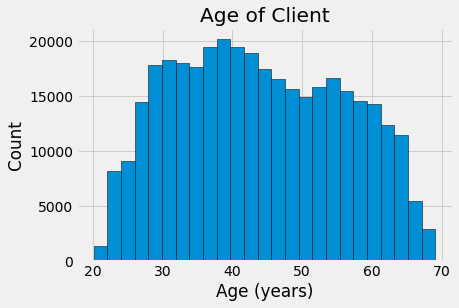

In [31]:
# Set the style of plots
plt.style.use('fivethirtyeight')

# Plot the distribution of ages in years
plt.hist(application_mix['DAYS_BIRTH'] / 365, edgecolor = 'k', bins = 25)
plt.title('Age of Client'); plt.xlabel('Age (years)'); plt.ylabel('Count');

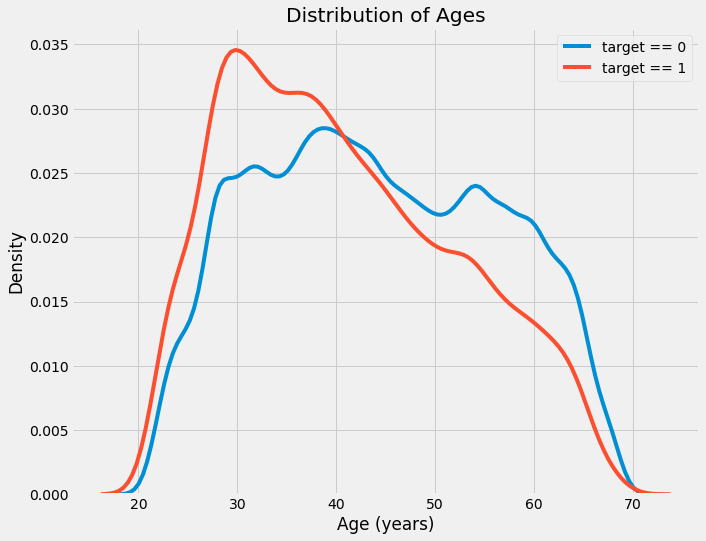

In [32]:
plt.figure(figsize = (10, 8))

# KDE plot of loans that were repaid on time
sns.kdeplot(application_mix.loc[application_mix['TARGET'] == 0, 'DAYS_BIRTH'] / 365, label = 'target == 0')

# KDE plot of loans which were not repaid on time
sns.kdeplot(application_mix.loc[application_mix['TARGET'] == 1, 'DAYS_BIRTH'] / 365, label = 'target == 1')

# Labeling of plot
plt.xlabel('Age (years)'); plt.ylabel('Density'); plt.title('Distribution of Ages');

In [33]:
# Extract the EXT_SOURCE variables and show correlations
ext_data = application_mix[['TARGET', 'EXT_SOURCE_1','EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']]
ext_data_corrs = ext_data.corr()
ext_data_corrs

,TARGET,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,DAYS_BIRTH
TARGET,1.000000,-0.155317,-0.160472,-0.178919,-0.078239
EXT_SOURCE_1,-0.155317,1.000000,0.212987,0.181390,0.586844
EXT_SOURCE_2,-0.160472,0.212987,1.000000,0.108480,0.095338
EXT_SOURCE_3,-0.178919,0.181390,0.108480,1.000000,0.201932
DAYS_BIRTH,-0.078239,0.586844,0.095338,0.201932,1.000000


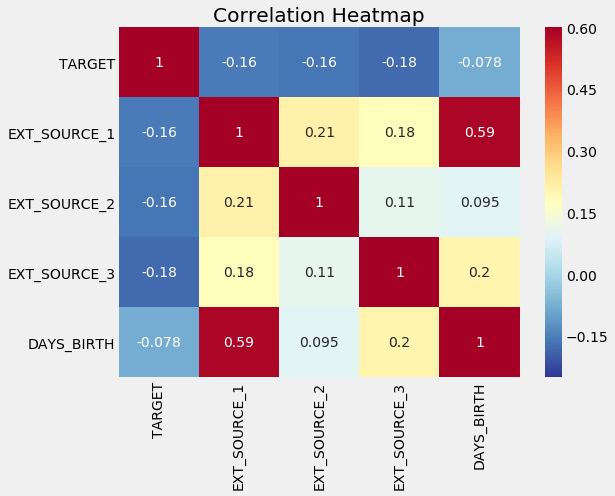

In [34]:
plt.figure(figsize = (8, 6))

# Heatmap of correlations
sns.heatmap(ext_data_corrs, cmap = plt.cm.RdYlBu_r, vmin = -0.25, annot = True, vmax = 0.6)
plt.title('Correlation Heatmap');

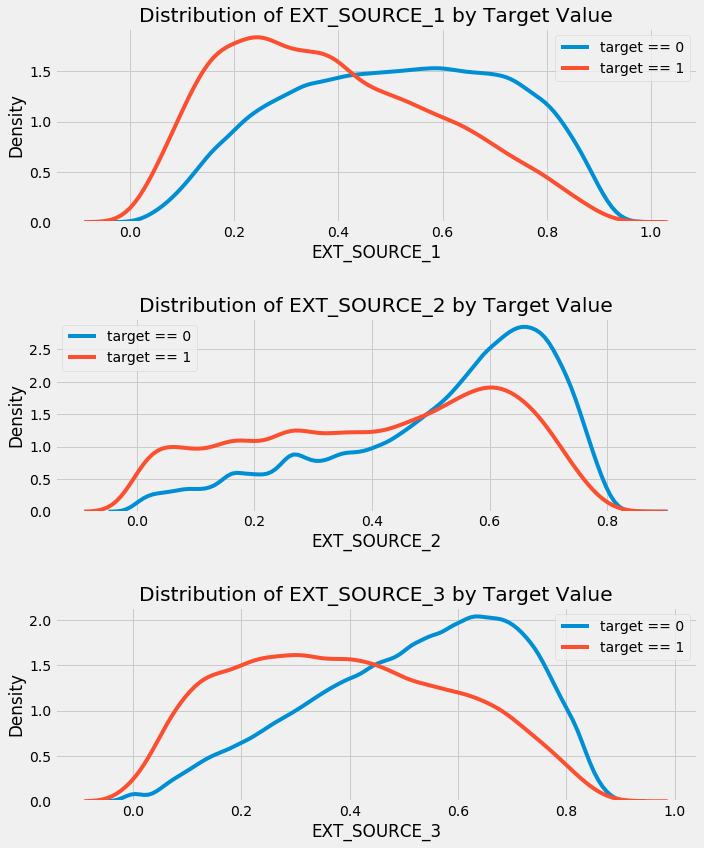

In [35]:
plt.figure(figsize = (10, 12))

# iterate through the sources
for i, source in enumerate(['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']):
    
    # create a new subplot for each source
    plt.subplot(3, 1, i + 1)
    # plot repaid loans
    sns.kdeplot(application_mix.loc[application_mix['TARGET'] == 0, source], label = 'target == 0')
    # plot loans that were not repaid
    sns.kdeplot(application_mix.loc[application_mix['TARGET'] == 1, source], label = 'target == 1')
    
    # Label the plots
    plt.title('Distribution of %s by Target Value' % source)
    plt.xlabel('%s' % source); plt.ylabel('Density');
    
plt.tight_layout(h_pad = 2.5)

# 3. Miscellaneous Handling

## Check Missing Data

In [36]:
# checking missing data
total = application_mix.isnull().sum().sort_values(ascending = False)
percent = (application_mix.isnull().sum()/application_mix.isnull().count()*100).sort_values(ascending = False)
missing_application_mix_data  = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_application_mix_data.head(20)

,Total,Percent
COMMONAREA_MODE,248360,69.714109
COMMONAREA_AVG,248360,69.714109
COMMONAREA_MEDI,248360,69.714109
NONLIVINGAPARTMENTS_MODE,246861,69.293343
NONLIVINGAPARTMENTS_AVG,246861,69.293343
NONLIVINGAPARTMENTS_MEDI,246861,69.293343
FONDKAPREMONT_MODE,243092,68.235393
LIVINGAPARTMENTS_AVG,242979,68.203674
LIVINGAPARTMENTS_MEDI,242979,68.203674
LIVINGAPARTMENTS_MODE,242979,68.203674


In [37]:
# checking missing data
total = POS_CASH_balance.isnull().sum().sort_values(ascending = False)
percent = (POS_CASH_balance.isnull().sum()/POS_CASH_balance.isnull().count()*100).sort_values(ascending = False)
missing_POS_CASH_balance_data  = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_POS_CASH_balance_data.head(3)

,Total,Percent
CNT_INSTALMENT_FUTURE,26087,0.260835
CNT_INSTALMENT,26071,0.260675
SK_DPD_DEF,0,0.000000


In [38]:
# checking missing data
total = bureau_balance.isnull().sum().sort_values(ascending = False)
percent = (bureau_balance.isnull().sum()/bureau_balance.isnull().count()*100).sort_values(ascending = False)
missing_bureau_balance_data  = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_bureau_balance_data.head(3)

,Total,Percent
STATUS,0,0.0
MONTHS_BALANCE,0,0.0
SK_ID_BUREAU,0,0.0


In [39]:
# checking missing data
total = previous_application.isnull().sum().sort_values(ascending = False)
percent = (previous_application.isnull().sum()/previous_application.isnull().count()*100).sort_values(ascending = False)
missing_previous_application_data  = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_previous_application_data.head(15)

,Total,Percent
RATE_INTEREST_PRIVILEGED,1664263,99.643698
RATE_INTEREST_PRIMARY,1664263,99.643698
RATE_DOWN_PAYMENT,895844,53.636480
AMT_DOWN_PAYMENT,895844,53.636480
NAME_TYPE_SUITE,820405,49.119754
DAYS_TERMINATION,673065,40.298129
NFLAG_INSURED_ON_APPROVAL,673065,40.298129
DAYS_FIRST_DRAWING,673065,40.298129
DAYS_FIRST_DUE,673065,40.298129
DAYS_LAST_DUE_1ST_VERSION,673065,40.298129


In [40]:
# checking missing data
total = installments_payments.isnull().sum().sort_values(ascending = False)
percent = (installments_payments.isnull().sum()/installments_payments.isnull().count()*100).sort_values(ascending = False)
missing_installments_payments_data  = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_installments_payments_data.head(3)

,Total,Percent
AMT_PAYMENT,2905,0.021352
DAYS_ENTRY_PAYMENT,2905,0.021352
AMT_INSTALMENT,0,0.000000


In [41]:
# checking missing data
total = credit_card_balance.isnull().sum().sort_values(ascending = False)
percent = (credit_card_balance.isnull().sum()/credit_card_balance.isnull().count()*100).sort_values(ascending = False)
missing_credit_card_balance_data  = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_credit_card_balance_data.head(10)

,Total,Percent
AMT_PAYMENT_CURRENT,767988,19.998063
AMT_DRAWINGS_OTHER_CURRENT,749816,19.524872
CNT_DRAWINGS_POS_CURRENT,749816,19.524872
CNT_DRAWINGS_OTHER_CURRENT,749816,19.524872
CNT_DRAWINGS_ATM_CURRENT,749816,19.524872
AMT_DRAWINGS_ATM_CURRENT,749816,19.524872
AMT_DRAWINGS_POS_CURRENT,749816,19.524872
CNT_INSTALMENT_MATURE_CUM,305236,7.948208
AMT_INST_MIN_REGULARITY,305236,7.948208
SK_DPD_DEF,0,0.000000


In [42]:
# checking missing data
total = bureau.isnull().sum().sort_values(ascending = False)
percent = (bureau.isnull().sum()/bureau.isnull().count()*100).sort_values(ascending = False)
missing_bureau_data  = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_bureau_data.head(8)

,Total,Percent
AMT_ANNUITY,1226791,71.473490
AMT_CREDIT_MAX_OVERDUE,1124488,65.513264
DAYS_ENDDATE_FACT,633653,36.916958
AMT_CREDIT_SUM_LIMIT,591780,34.477415
AMT_CREDIT_SUM_DEBT,257669,15.011932
DAYS_CREDIT_ENDDATE,105553,6.149573
AMT_CREDIT_SUM,13,0.000757
CREDIT_TYPE,0,0.000000


## Checking Duplicates Value

In [43]:
print('Number of duplicated data in application_train data', application_mix.duplicated().sum())
print('Number of duplicated data in POS_CASH_balance data', POS_CASH_balance.duplicated().sum())
print('Number of duplicated data in bureau_balance data', bureau_balance.duplicated().sum())
print('Number of duplicated data in previous_application data', previous_application.duplicated().sum())
print('Number of duplicated data in installments_payments data', installments_payments.duplicated().sum())
print('Number of duplicated data in credit_card_balance data', credit_card_balance.duplicated().sum())
print('Number of duplicated data in bureau data', bureau.duplicated().sum())

Number of duplicated data in application_train data 0
Number of duplicated data in POS_CASH_balance data 0
Number of duplicated data in bureau_balance data 0
Number of duplicated data in previous_application data 0
Number of duplicated data in installments_payments data 0
Number of duplicated data in credit_card_balance data 0
Number of duplicated data in bureau data 0


## Drop Missing Value COlumn

In [44]:
def missing_values_stat_in_columns(df):
    mis_val = df.isnull().sum()
    mis_val_percent = 100 * df.isnull().sum() / len(df)
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
    mis_val_table_ren_columns = mis_val_table.rename(columns = {0 : 'Missing Values In Column', 1 : '% of Total Values In Column'})
    mis_val_table_ren_columns = mis_val_table_ren_columns[mis_val_table_ren_columns.iloc[:,1] != 0].sort_values('% of Total Values In Column', ascending=False).round(1)
    print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
    return mis_val_table_ren_columns

def missing_value_manipulation(df, missing_percentage = 30.0): # TODO: Shoul be used for generating column list to drop
    missing_percentage_df = missing_values_stat_in_columns(df)
    cols_to_drop = set()
    for index, row in missing_percentage_df.iterrows():
        if row['% of Total Values In Column'] >= float(missing_percentage):
            cols_to_drop.add(index)
#     print(cols_to_drop)
    if 'EXT_SOURCE_1' in cols_to_drop:
        cols_to_drop.remove('EXT_SOURCE_1')
    print('There are '+str(len(cols_to_drop))+' columns that have more than 30% missing value.')
    return cols_to_drop

In [45]:
application_mix = application_mix.drop(missing_value_manipulation(application_mix),1)

Your selected dataframe has 122 columns.
There are 68 columns that have missing values.
There are 49 columns that have more than 30% missing value.


In [46]:
POS_CASH_balance = POS_CASH_balance.drop(missing_value_manipulation(POS_CASH_balance),1)

Your selected dataframe has 8 columns.
There are 2 columns that have missing values.
There are 0 columns that have more than 30% missing value.


In [47]:
bureau_balance = bureau_balance.drop(missing_value_manipulation(bureau_balance),1)

Your selected dataframe has 3 columns.
There are 0 columns that have missing values.
There are 0 columns that have more than 30% missing value.


In [48]:
previous_application = previous_application.drop(missing_value_manipulation(previous_application),1)

Your selected dataframe has 37 columns.
There are 16 columns that have missing values.
There are 11 columns that have more than 30% missing value.


In [49]:
installments_payments = installments_payments.drop(missing_value_manipulation(installments_payments),1)

Your selected dataframe has 8 columns.
There are 2 columns that have missing values.
There are 0 columns that have more than 30% missing value.


In [50]:
credit_card_balance = credit_card_balance.drop(missing_value_manipulation(credit_card_balance),1)

Your selected dataframe has 23 columns.
There are 9 columns that have missing values.
There are 0 columns that have more than 30% missing value.


In [51]:
a


Your selected dataframe has 17 columns.
There are 7 columns that have missing values.
There are 4 columns that have more than 30% missing value.


In [52]:
print('Size of application_train data', application_train.shape)
print('Size of POS_CASH_balance data', POS_CASH_balance.shape)
print('Size of bureau_balance data', bureau_balance.shape)
print('Size of previous_application data', previous_application.shape)
print('Size of installments_payments data', installments_payments.shape)
print('Size of credit_card_balance data', credit_card_balance.shape)
print('Size of bureau data', bureau.shape)

Size of application_train data (307511, 122)
Size of POS_CASH_balance data (10001358, 8)
Size of bureau_balance data (27299925, 3)
Size of previous_application data (1670214, 26)
Size of installments_payments data (13605401, 8)
Size of credit_card_balance data (3840312, 23)
Size of bureau data (1716428, 13)


## Filling Missing Value

In [53]:
def filling_na(df):
    object_list = df.select_dtypes('object').columns
    number_list = df.select_dtypes('number').columns
    number_list = number_list[~number_list.isin(['TARGET'])]
    df[number_list] = df[number_list].fillna(df[number_list].mean())
    df[object_list] = df[object_list].fillna(df[object_list].mode().iloc[0])
    return df

In [54]:
application_mix = filling_na(application_mix)

In [55]:
POS_CASH_balance = filling_na(POS_CASH_balance)

In [56]:
bureau_balance = filling_na(bureau_balance)

In [57]:
previous_application = filling_na(previous_application)

In [58]:
installments_payments = filling_na(installments_payments)

In [59]:
credit_card_balance = filling_na(credit_card_balance)

In [60]:
bureau = filling_na(bureau)

# 4 Dummy Variable & Selecting Table

In [61]:
prev_application_dummies = pd.get_dummies(previous_application)
bureau_dummies = pd.get_dummies(bureau)
application_mix_dummies = pd.get_dummies(application_mix)

# 5 Transformation & Aggregation

In [62]:
prev_application_dummies = prev_application_dummies.drop(['SK_ID_PREV'],1)
bureau_dummies = bureau_dummies.drop(['SK_ID_BUREAU'],1)

In [63]:
prev_application_grouped = prev_application_dummies.groupby(['SK_ID_CURR'],as_index=False).mean()
bureau_grouped = bureau_dummies.groupby(['SK_ID_CURR'],as_index=False).mean()

# 6 JOINING TABLE

In [64]:
application_merged1 = pd.merge(application_mix_dummies,prev_application_grouped,how='left',on=['SK_ID_CURR'])
application_merged2 = pd.merge(application_merged1,bureau_grouped,how='left',on=['SK_ID_CURR'])

In [65]:
print('Size of full application data', application_merged2.shape)
application_merged2.head()

Size of full application data (356255, 344)


,AMT_ANNUITY_x,AMT_CREDIT_x,AMT_GOODS_PRICE_x,AMT_INCOME_TOTAL,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_YEAR,...,CREDIT_TYPE_Interbank credit,CREDIT_TYPE_Loan for business development,CREDIT_TYPE_Loan for purchase of shares (margin lending),CREDIT_TYPE_Loan for the purchase of equipment,CREDIT_TYPE_Loan for working capital replenishment,CREDIT_TYPE_Microloan,CREDIT_TYPE_Mobile operator loan,CREDIT_TYPE_Mortgage,CREDIT_TYPE_Real estate loan,CREDIT_TYPE_Unknown type of loan
0,24700.5,406597.5,351000.0,202500.0,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,35698.5,1293502.5,1129500.0,270000.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,6750.0,135000.0,135000.0,67500.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,29686.5,312682.5,297000.0,135000.0,0.006281,0.005808,0.231697,0.304399,0.029995,1.911564,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,21865.5,513000.0,513000.0,121500.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Checking Missing Value

In [66]:
# checking missing data
total = application_merged2.isnull().sum().sort_values(ascending = False)
percent = (application_merged2.isnull().sum()/application_merged2.isnull().count()*100).sort_values(ascending = False)
missing_application_mix_data  = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_application_mix_data.head(20)

,Total,Percent
CREDIT_TYPE_Unknown type of loan,50444,14.159521
CREDIT_CURRENCY_currency 3,50444,14.159521
CREDIT_TYPE_Real estate loan,50444,14.159521
DAYS_CREDIT,50444,14.159521
CREDIT_DAY_OVERDUE,50444,14.159521
DAYS_CREDIT_ENDDATE,50444,14.159521
CNT_CREDIT_PROLONG,50444,14.159521
AMT_CREDIT_SUM,50444,14.159521
AMT_CREDIT_SUM_DEBT,50444,14.159521
DAYS_CREDIT_UPDATE,50444,14.159521


# 7 Training and Testing Split

## Splitting X and Y

In [67]:
X = application_merged2.drop(['TARGET'],1)
y = application_merged2['TARGET']
X = X.fillna(0)

In [68]:
X_train = X[~y.isnull()]
X_validation = X[y.isnull()]
y_train = y[~y.isnull()]

## Dropping ID

In [69]:
train_id = X_train['SK_ID_CURR']
validation_id = X_validation['SK_ID_CURR']
X_train = X_train.drop(['SK_ID_CURR'],1)
X_validation = X_validation.drop(['SK_ID_CURR'],1)

# 8. Modeling

## Baseline

In [70]:
from sklearn.model_selection import train_test_split
X_training,X_testing,y_training,y_testing = train_test_split(X_train,y_train,stratify=y_train,test_size = 0.5,random_state = 123)

In [71]:
print('Size of X_training :',X_training.shape)
print('Size of X_testing :',X_testing.shape)

Size of X_training : (153755, 342)
Size of X_testing : (153756, 342)


In [72]:
from sklearn.tree import DecisionTreeClassifier
dtc = DecisionTreeClassifier()
start = dt.now()
dtc.fit(X_training,y_training)
print(dt.now()-start)

0:00:30.977778


In [73]:
from sklearn.metrics import roc_auc_score
y_pred = dtc.predict_proba(X_testing)[:,1]
roc_auc_score(y_testing,y_pred)

0.5364239508327869

## Feature Importances by Random Forest

In [74]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier()
start = dt.now()
rfc.fit(X_training,y_training)
print(dt.now()-start)

0:00:08.948540


In [75]:
from sklearn.metrics import roc_auc_score
y_pred = rfc.predict_proba(X_testing)[:,1]
roc_auc_score(y_testing,y_pred)

0.629177459473724

In [76]:
# function for creating a feature importance dataframe
def imp_df(column_names, importances):
    df = pd.DataFrame({'feature': column_names,
                       'feature_importance': importances}) \
           .sort_values('feature_importance', ascending = False) \
           .reset_index(drop = True)
    return df

In [77]:
base_imp = imp_df(X_training.columns, rfc.feature_importances_)
base_imp.head(25)

,feature,feature_importance
0,EXT_SOURCE_2,0.033533
1,EXT_SOURCE_3,0.026986
2,DAYS_ID_PUBLISH,0.017390
3,DAYS_REGISTRATION,0.017382
4,DAYS_BIRTH,0.016952
5,EXT_SOURCE_1,0.016419
6,AMT_ANNUITY_x,0.015507
7,DAYS_EMPLOYED,0.014648
8,AMT_CREDIT_x,0.014612
9,DAYS_CREDIT_ENDDATE,0.014577


## Feature Selection

In [78]:
best_feature = list(base_imp[base_imp['feature_importance']>0.01]['feature'])
best_feature

['EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'DAYS_ID_PUBLISH',
 'DAYS_REGISTRATION',
 'DAYS_BIRTH',
 'EXT_SOURCE_1',
 'AMT_ANNUITY_x',
 'DAYS_EMPLOYED',
 'AMT_CREDIT_x',
 'DAYS_CREDIT_ENDDATE',
 'DAYS_CREDIT',
 'DAYS_CREDIT_UPDATE',
 'AMT_APPLICATION',
 'DAYS_LAST_PHONE_CHANGE',
 'DAYS_DECISION',
 'HOUR_APPR_PROCESS_START_y',
 'AMT_CREDIT_SUM',
 'AMT_GOODS_PRICE_y',
 'AMT_ANNUITY_y',
 'AMT_CREDIT_y',
 'REGION_POPULATION_RELATIVE',
 'SELLERPLACE_AREA',
 'CNT_PAYMENT',
 'AMT_INCOME_TOTAL',
 'AMT_GOODS_PRICE_x',
 'HOUR_APPR_PROCESS_START_x',
 'AMT_CREDIT_SUM_DEBT']

In [79]:
X_all_train_selected = X_train[best_feature]
X_train_selected = X_training[best_feature]
X_test_selected = X_testing[best_feature]
X_valid_selected = X_validation[best_feature]

In [80]:
def modeling(x,y):
    #############################################
    
    # STRATIFIED K FOLD
    from sklearn.model_selection import StratifiedKFold
    #Linear Model
    from sklearn.linear_model import LogisticRegression
    from sklearn.tree import DecisionTreeClassifier
    
    
    #Ensemble
    from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier,BaggingClassifier,GradientBoostingClassifier
    
    #Cross Val Score
    from sklearn.model_selection import cross_val_score
    
    #XGBOOST
    from xgboost import XGBClassifier
    
    #################################################
    
    #linear Model
    logreg = LogisticRegression(random_state = 123)
    
    # Tree
    dt = DecisionTreeClassifier(random_state=123)
    #Ensemble
    randomforest = RandomForestClassifier()
    ada = AdaBoostClassifier()
    gdc = GradientBoostingClassifier()
    bagging = BaggingClassifier()
    xgb= XGBClassifier()
    
    
    classifiers = [logreg,dt,randomforest,bagging,ada,gdc, xgb]
    for clf, label in zip(classifiers, 
                      ['Logistic Regression',
                       'Decision Tree',
                       'Random Forest',
                       'Bagging',
                       'AdaBoost',
                       'GradBoost',
                      'XGBoost']):

        scores = cross_val_score(clf, x, y, cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=123), scoring='roc_auc')
        print("AUC of ROC : %0.4f (+/- %0.4f) [%s]" 
              % (scores.mean(), scores.std(), label))

In [81]:
modeling(X_train_selected,y_training)

Accuracy: 0.6503 (+/- 0.0006) [Logistic Regression]
Accuracy: 0.5381 (+/- 0.0021) [Decision Tree]
Accuracy: 0.6414 (+/- 0.0034) [Random Forest]
Accuracy: 0.6356 (+/- 0.0038) [Bagging]
Accuracy: 0.7375 (+/- 0.0051) [AdaBoost]
Accuracy: 0.7474 (+/- 0.0044) [GradBoost]
Accuracy: 0.7470 (+/- 0.0050) [XGBoost]


## Evaluate Overall Model

In [114]:
from sklearn.metrics import classification_report
from xgboost import XGBClassifier
xgb = XGBClassifier()
xgb.fit(X_train_selected,y_training)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [115]:
y_pred = xgb.predict(X_test_selected)
y_proba_pred = xgb.predict_proba(X_test_selected)[:,1]

In [116]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_testing,y_proba_pred)

0.7463469148626569

In [84]:
print(classification_report(y_testing,y_pred))

              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96    141343
         1.0       0.58      0.01      0.01     12413

    accuracy                           0.92    153756
   macro avg       0.75      0.50      0.49    153756
weighted avg       0.89      0.92      0.88    153756



In [88]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_testing,y_pred)

array([[141275,     68],
       [ 12319,     94]], dtype=int64)

# 8a Imbalance Dataset

In [92]:
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler()
rus.fit(X_train_selected,y_training)

RandomUnderSampler(random_state=None, ratio=None, replacement=False,
                   return_indices=False, sampling_strategy='auto')

In [99]:
X_train_rus,y_training_rus = rus.fit_resample(X_train_selected,y_training)
X_train_rus = pd.DataFrame(X_train_rus,columns = X_train_selected.columns)

In [100]:
xgb = XGBClassifier()
xgb.fit(X_train_rus,y_training_rus)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [111]:
y_pred = xgb.predict(X_test_selected)
y_proba_pred = xgb.predict_proba(X_test_selected)[:,1]

In [113]:
roc_auc_score(y_testing,y_proba_pred)

0.7458075341055435

In [102]:
print(classification_report(y_testing,y_pred))

              precision    recall  f1-score   support

         0.0       0.96      0.68      0.80    141343
         1.0       0.16      0.68      0.26     12413

    accuracy                           0.68    153756
   macro avg       0.56      0.68      0.53    153756
weighted avg       0.90      0.68      0.75    153756



In [103]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_testing,y_pred)

array([[96569, 44774],
       [ 3979,  8434]], dtype=int64)

In [129]:
y_testing.value_counts(normalize=True)

0.0    0.919268
1.0    0.080732
Name: TARGET, dtype: float64

# 9. Predicting DataTest

In [85]:
from xgboost import XGBClassifier
xgb = XGBClassifier()
xgb.fit(X_all_train_selected,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [86]:
def make_submission(clf,name_file = 'submission.csv'):
    df_valid_id = pd.DataFrame()
    y_pred = clf.predict_proba(X_valid_selected)
    y_pred = y_pred[:,1]
    df_valid_id =  pd.DataFrame(validation_id)
    df_valid_id['TARGET'] = y_pred
    df_valid_id.to_csv(name_file,index=False)
    return df_valid_id

In [87]:
make_submission(xgb)

,SK_ID_CURR,TARGET
307511,100001,0.052378
307512,100005,0.101263
307513,100013,0.031505
307514,100028,0.036935
307515,100038,0.170357
307516,100042,0.056631
307517,100057,0.024785
307518,100065,0.042669
307519,100066,0.030044
307520,100067,0.211282


# 10. SUBMIT!!!

# 11. Business Simulation

Kita bisa asumsikan
- setiap customer akan meminjam 1 juta rupiah 
- interest rate sebesar 2%
- dengan tenor (cicilan) 3 bulan

Dengan asumsi berikut maka kita akan mendapatkan return sebesar 1,060,000 per orang

--------------

jika kita menggunakan data testing kita akan mendapatkan 
- 153,756 customer

dengan spesifikasi
- 141,343 good
- 12,413 bad

------------

Apabila kita memberikan pinjaman **tanpa menggunakan machine learning model** maka cost yang akan dikeluarkan sebesar 

**153 B**

Sedangkan dengan resiko customer bad tidak akan melakukan repayment sama sekali maka return yang akan didapatkan sebesar

**149 B (-2.6%)**

-----------

Apabila kita memberikan pinjaman **dengan menggunakan machine learning model** maka 

jumlah customer yang akan diprediksi good sebanyak 100,548 customer

Dengan keadaan aktual dari customer :
- 96,569 good
- 3,979 bad

Maka cost yang akan dikeluarkan sebesar 

**100 B**

Dengan menggunakan simulasi yang sama kita bisa mendapatkan return sebesar

**102 B (+2%)**

# 12. Credit

Created By ***Abdullah Ghifari***

Data Scientist - Bukalapak

linkedin : https://www.linkedin.com/in/abdullah-ghifari/

WA : +62 89 66 4444 201

Email : abdulghif@gmail.com